In [1]:
import pandas as pd
xlsx_file = pd.ExcelFile("C:\\Users\\Administrator\\Desktop\\NJTPA\\Sample Planning Study Data_ESM_V12.5_JFV.xlsx")
#xlsx_file.sheet_names

In [2]:
data = xlsx_file.parse("Recommendations")
#data.head()

In [3]:
data.columns

Index(['Recommendation_Title', 'Planning_Source', 'SourceID', 'Planning_Topic',
       'Planning_Topic_2', 'Summary_of_Recommendation', 'Action1',
       'Sub_Action1', 'Action_2', 'Sub_Action2', 'Action3', 'Sub_Action3',
       'Action4', 'Sub_Action4', 'Tags', 'Sub_Tags', 'Status', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')

In [4]:
from transformer import PreProcessingTransformer

processor = PreProcessingTransformer(field="Summary_of_Recommendation")
rs1 = processor.fit_transform(data)
processor = PreProcessingTransformer(field="Recommendation_Title")
rs2 = processor.fit_transform(data)

Rec_data = [' '.join([x1, x2]) for x1, x2 in zip(rs2, rs1)]

In [5]:
processor = PreProcessingTransformer(field="Planning_Topic")
rs1 = processor.fit_transform(data)
processor = PreProcessingTransformer(field="Planning_Source")
rs2 = processor.fit_transform(data)

Source_data = [' '.join([x1, x2]) for x1, x2 in zip(rs1, rs2)]

In [6]:
class MyTokenizer(object):
    def __call__(self,s):
        return s.split()

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
count_vect = CountVectorizer(encoding='utf-8', stop_words = 'english',
                             tokenizer=MyTokenizer(), ngram_range = (1,2),binary = False, min_df = 2)
tfidf = TfidfTransformer(use_idf=False,norm='l2')
ngram = count_vect.fit_transform([str(x).lower() for x in Rec_data + Source_data])
ngram_norm = tfidf.fit_transform(ngram)

bag_of_words = count_vect.get_feature_names()
with open("C:\\Users\\Administrator\\Desktop\\NJTPA\\BagOfWords.csv",'w',encoding='utf-8') as rsfile:
    for word in bag_of_words:
        rsfile.write(word+"\n")

len(bag_of_words)

3055

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
n_components = 10
lda = LatentDirichletAllocation(n_components=n_components, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(ngram_norm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [8]:
import numpy as np
dist = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
dist.shape

(10, 3055)

In [9]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "\t".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]) + "\n"
        message += "\t".join([str(dist[topic_idx][i])
                             for i in topic.argsort()[:-n_top_words - 1:-1]]) + "\n"
        print(message)
    print()
    
n_top_words = 20
tf_feature_names = count_vect.get_feature_names()
#print_top_words(lda, tf_feature_names, n_top_words)

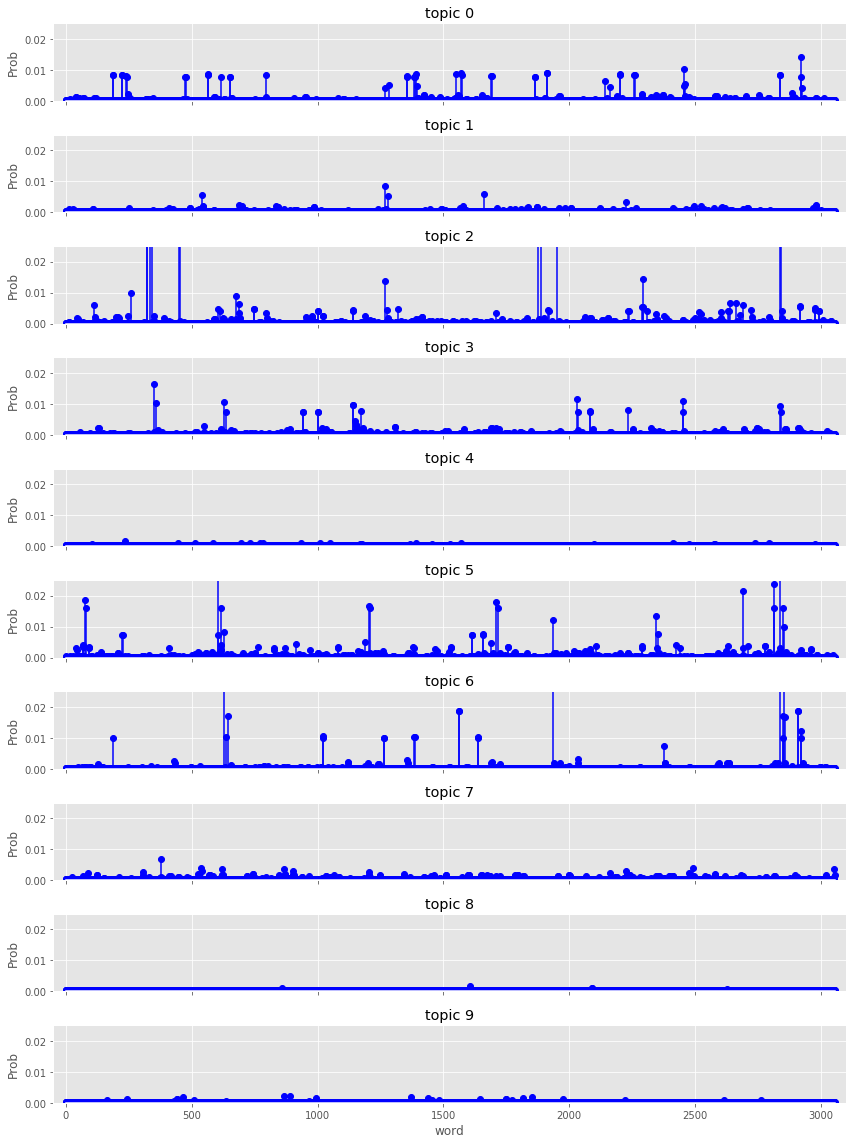

In [10]:
import matplotlib.pyplot as plt
try:
    plt.style.use('ggplot')
except:
    # version of matplotlib might not be recent
    pass

f, ax= plt.subplots(n_components, 1, figsize=(12, 16), sharex=True)
for i, k in enumerate(range(n_components)):
    ax[i].stem(dist[k,:], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(-50,3100)
    ax[i].set_ylim(0, 0.025)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k))

ax[n_components-1].set_xlabel("word")

plt.tight_layout()
plt.show()

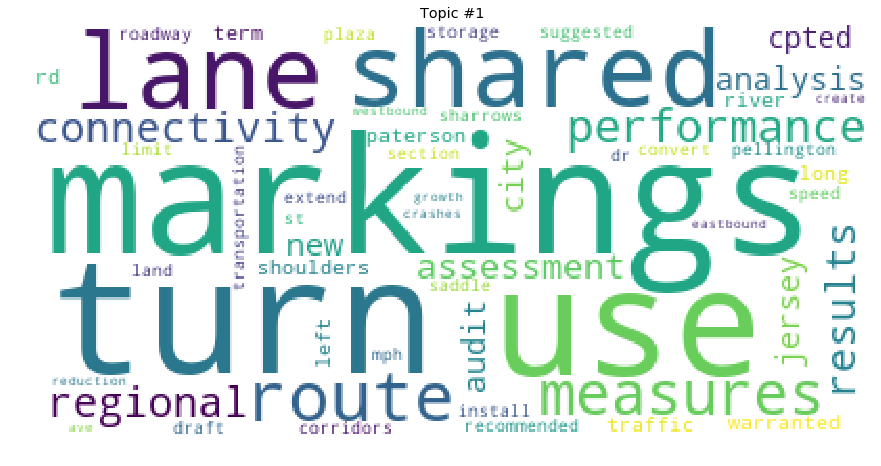

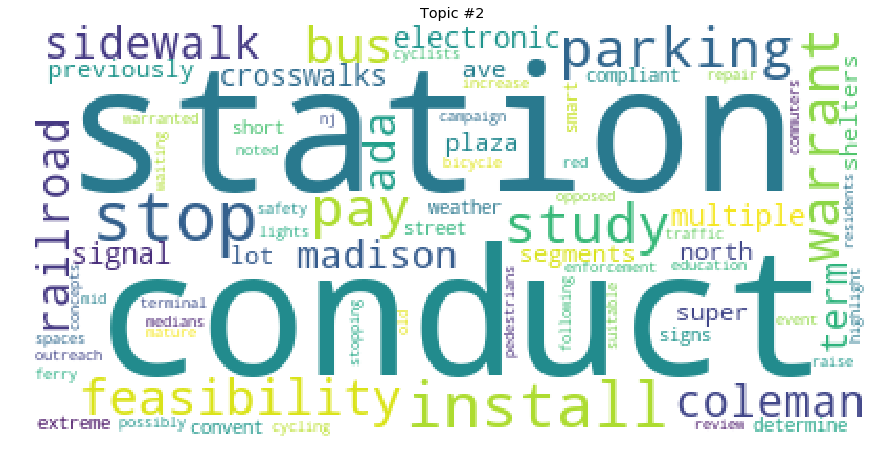

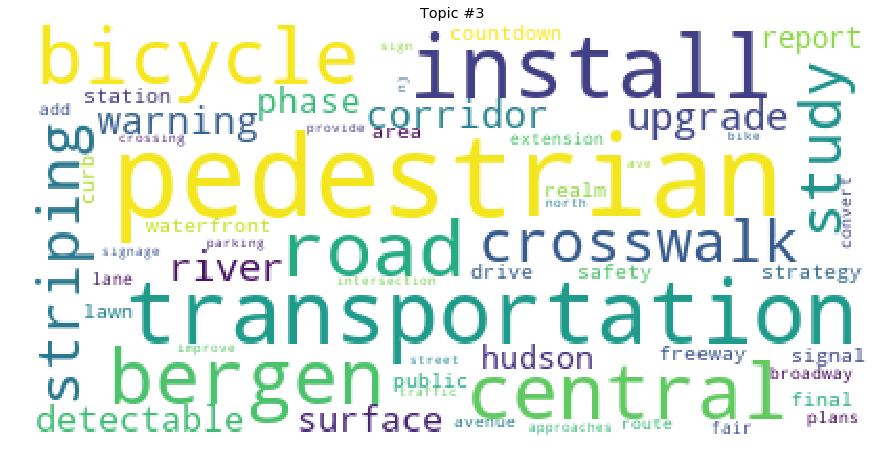

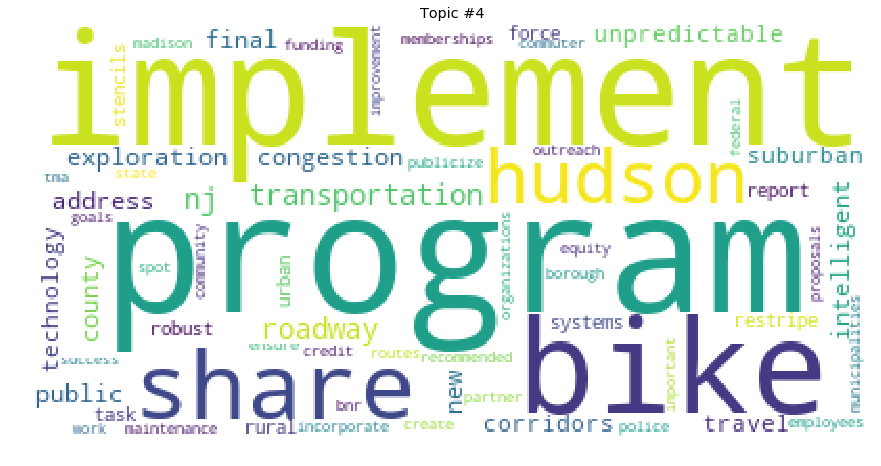

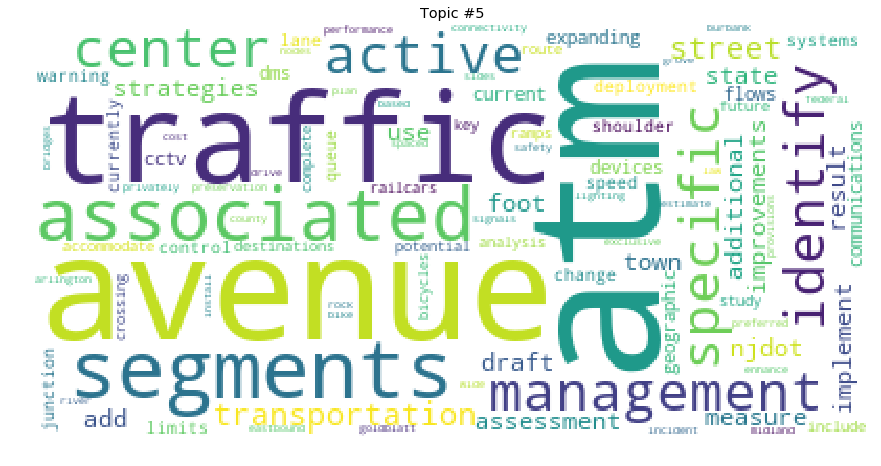

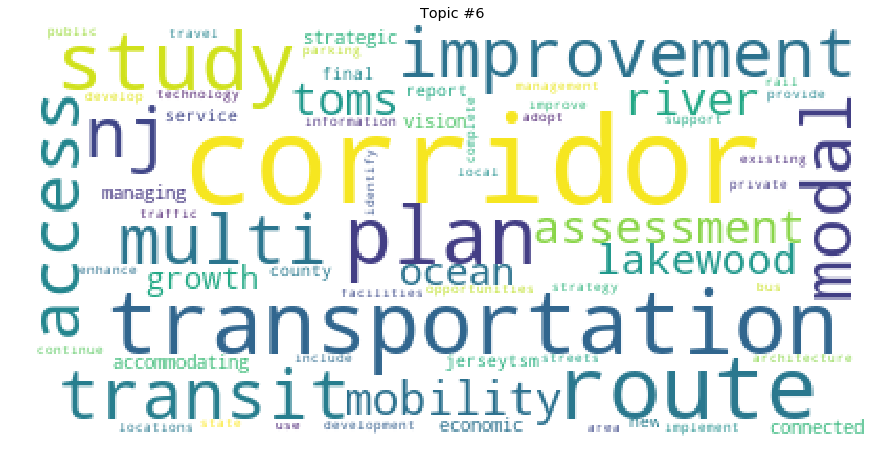

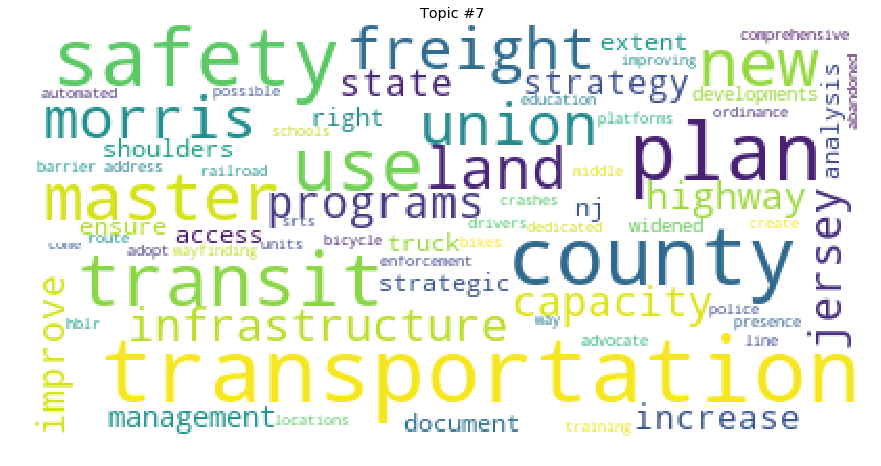

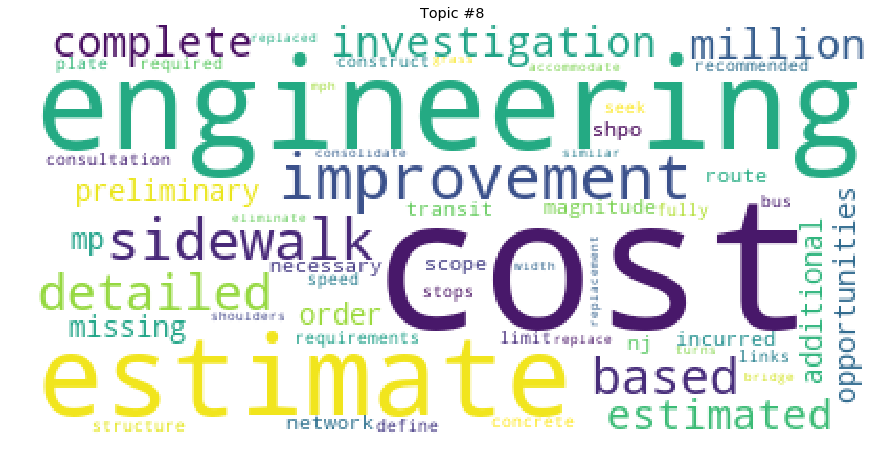

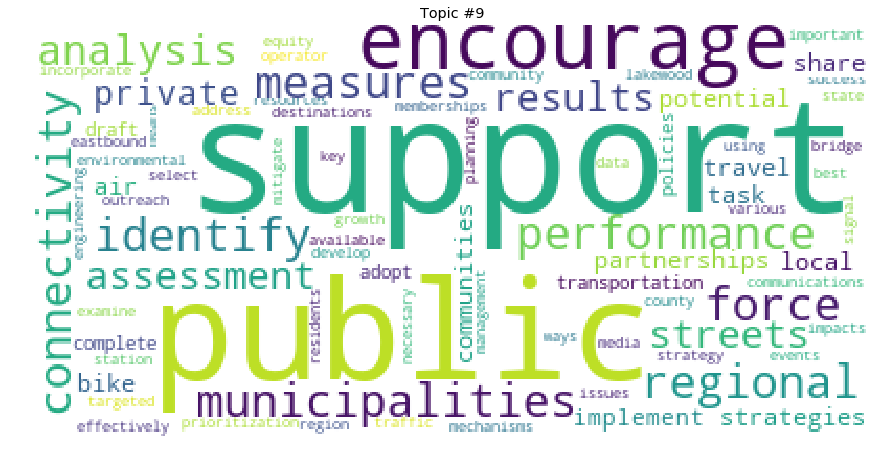

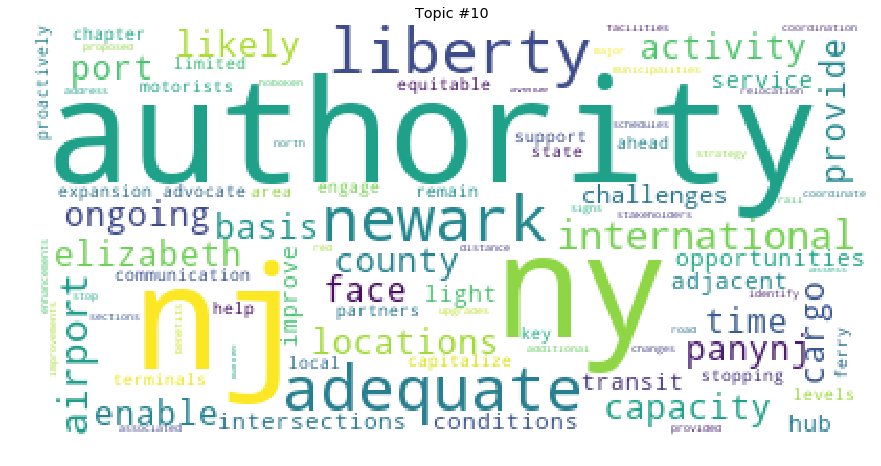

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
n_top_words = 100
for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(15,15))
    plt.imshow(WordCloud(background_color="white").generate(" ".join([tf_feature_names[i] 
                                                                      for i in topic.argsort()[:-n_top_words - 1:-1]])))
    plt.axis("off")
    plt.title("Topic #" + str(topic_idx+1))
    plt.show()
    #plt.savefig("".join["C:\\Users\\Administrator\\Desktop\\NJTPA\\topic\\Topic",str(topic_idx+1),".png"])

In [15]:
doc_topic = lda.transform(ngram_norm)

#for n in range(doc_topic.shape[0]):
#    #topic_most_pr = doc_topic[n].argmax()
#    topic_most_pr = doc_topic[n]
#    print("doc: {} topic: {}\n".format(n,topic_most_pr))
doc_topic.shape

(1560, 10)

In [16]:
doc_topic_comb = []
for i in range(data.shape[0]):
    doc_topic_comb.append(np.append(doc_topic[i], doc_topic[i+data.shape[0]]))
    
np.asarray(doc_topic_comb).shape

(780, 20)

In [17]:
from scipy.sparse import csr_matrix
ngram_norm_dense = csr_matrix(ngram_norm).toarray()
doc_matrix_comb = []
for i in range(data.shape[0]):
    doc_matrix_comb.append(np.append(doc_topic_comb[i],ngram_norm_dense[i]))

np.asarray(doc_matrix_comb).shape

(780, 3075)

In [18]:
from sklearn import metrics
#dist=metrics.pairwise.cosine_similarity(doc_topic_comb, doc_topic_comb)
dist=metrics.pairwise.cosine_similarity(doc_matrix_comb, doc_matrix_comb)
dist.shape

(780, 780)

In [19]:
dist_df = pd.DataFrame(dist, columns = np.arange(0, data.shape[0]))
dfa=data.Action1.values
source = data.SourceID.values
recs = data.Summary_of_Recommendation.values
rs = []
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        if dfa[i] == dfa[j]: action = 1
        else: action = 0
        if source[i]!=source[j]:
            rs.append(["-".join(["Rec",str(i+2),str(j+2)]),
                      dist_df.loc[i][j],
                      action,
                      (dist_df.loc[i][j]+action)/2,
                       source[i]==source[j],
                      source[i],
                      source[j],
                      recs[i].replace("\n"," "),
                      recs[j].replace("\n"," ")])

rs_df = pd.DataFrame(rs)
rs_df.columns = ["Rec_Link","Rec_Sim","Same_Action","Sim_Score","Same_Source","SourceA","SourceB","RecA","RecB"]

In [27]:
#rs_df.head()

In [29]:
writer = pd.ExcelWriter("".join(["C:\\PHD\\RA\\NJTPA\\Rec_relation_",str(n_components),"topics2.xlsx"]))
rs_df.to_excel(writer,"Sheet1")
writer.save()